C:\Users\willy\AppData\Local\Temp\ipykernel_22728\2375714173.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


RMSE para Tratamiento 1: 43.89425237947313
RMSE para Tratamiento 2: 116.3558194149146
RMSE para Tratamiento 3: 227.18984839404095


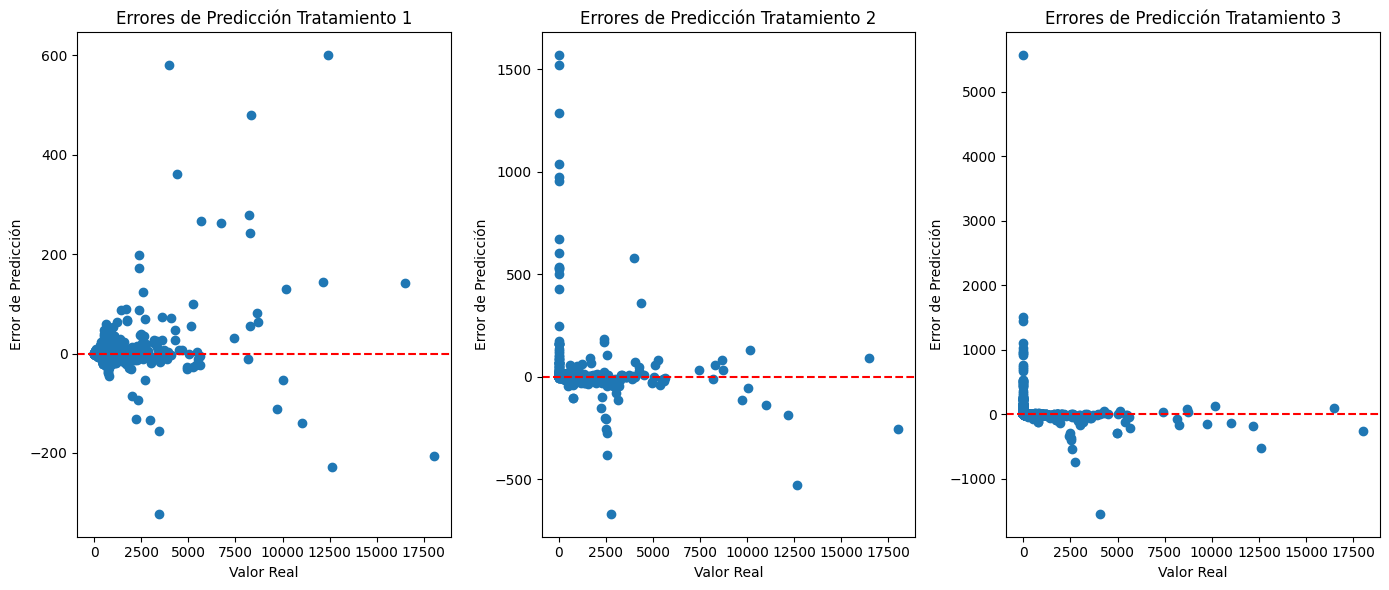

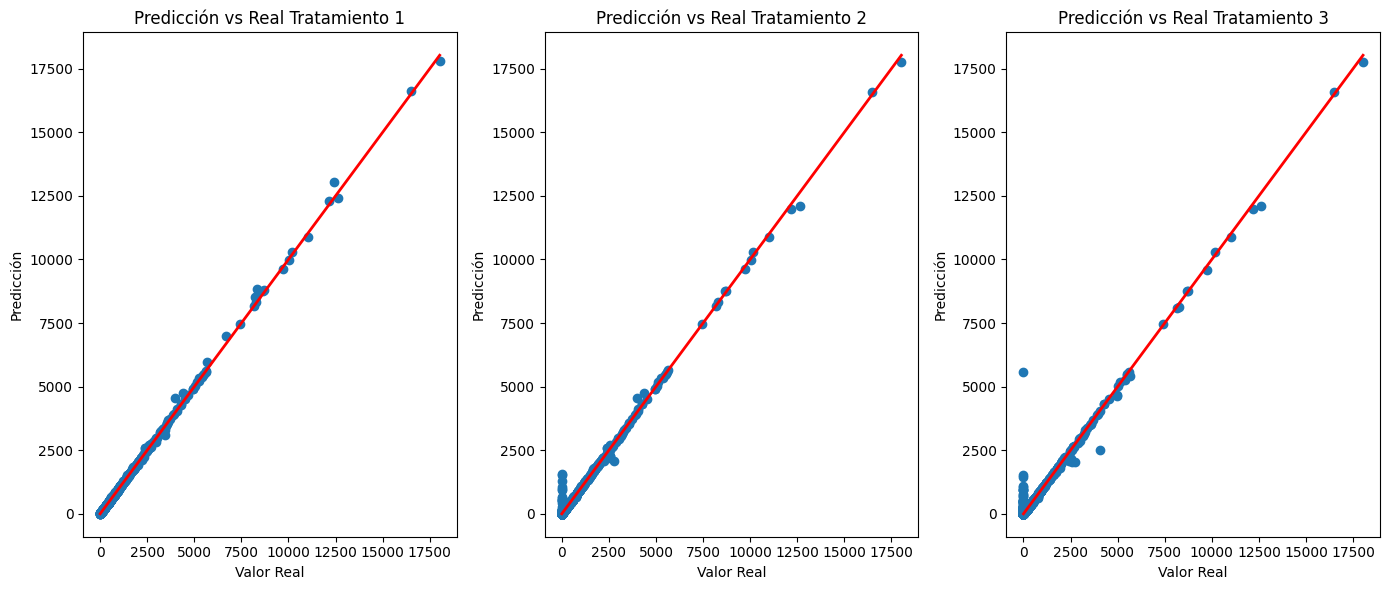

KeyError: 'PREDICCION_DEMANDA_TRATAMIENTO_1'

In [16]:
import pandas as pd

# Cargar los archivos
archivo_principal = "C:/tesis/Consulta Externa 2021.csv"  # Cambia por el nombre de tu archivo CSV
archivo_enfermedades = "C:/tesis/top50_enf.xlsx"  # Cambia por el nombre de tu archivo Excel

# Leer el archivo CSV con manejo de errores
try:
    # Intentar leer el archivo con detección automática de delimitadores
    df_principal = pd.read_csv(
        archivo_principal,
        encoding="utf-8",
        sep=None,  # Detectar automáticamente el delimitador
        engine="python",
        on_bad_lines="skip"  # Omitir líneas malformadas
    )
    print("Archivo CSV cargado exitosamente.")
    print(f"Primeras filas del archivo:\n{df_principal.head()}")
except pd.errors.EmptyDataError:
    print("Error: El archivo CSV está vacío o no contiene datos.")
    exit(1)
except pd.errors.ParserError as e:
    print(f"Error al analizar el archivo CSV: {e}")
    exit(1)
except Exception as e:
    print(f"Error inesperado al leer el archivo principal: {e}")
    exit(1)

# Leer el archivo Excel
try:
    df_enfermedades = pd.read_excel(archivo_enfermedades, sheet_name=0)  # Ajusta el sheet_name si es necesario
    print("Archivo Excel cargado exitosamente.")
except Exception as e:
    print(f"Error al leer el archivo de enfermedades: {e}")
    exit(1)

# Normalizar las columnas de código para evitar inconsistencias
if 'CODIGO_CIE10_1' in df_principal.columns and 'CODIGO_CIE10_1' in df_enfermedades.columns:
    df_principal['CODIGO_CIE10_1'] = df_principal['CODIGO_CIE10_1'].astype(str).str.strip().str.upper()
    df_enfermedades['CODIGO_CIE10_1'] = df_enfermedades['CODIGO_CIE10_1'].astype(str).str.strip().str.upper()
else:
    print("Error: No se encontraron las columnas 'CODIGO_CIE10_1' en uno de los archivos.")
    exit(1)

# Unir los datos para agregar las columnas de tratamientos
try:
    df_merge = pd.merge(
        df_principal,
        df_enfermedades[['CODIGO_CIE10_1', 'TRATAMIENTO 1', 'TRATAMIENTO 2', 'TRATAMIENTO 3']],
        on='CODIGO_CIE10_1',
        how='inner'  # Solo conserva las enfermedades que están en el top 50
    )
    print("Unión de datos completada.")
except KeyError as e:
    print(f"Error al realizar la unión de datos: {e}")
    exit(1)

# Guardar el resultado en un nuevo archivo CSV
archivo_resultante = "consultas_externas_actualizado.csv"
try:
    df_merge.to_csv(archivo_resultante, index=False, encoding="utf-8")
    print(f"Archivo procesado y guardado como '{archivo_resultante}'.")
except Exception as e:
    print(f"Error al guardar el archivo resultante: {e}")


C:\Users\willy\AppData\Local\Temp\ipykernel_5904\3542449255.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Mean Squared Error (MSE): 22360.203105658828
Root Mean Squared Error (RMSE): 149.53328427363195
R²: 0.9894774998254775


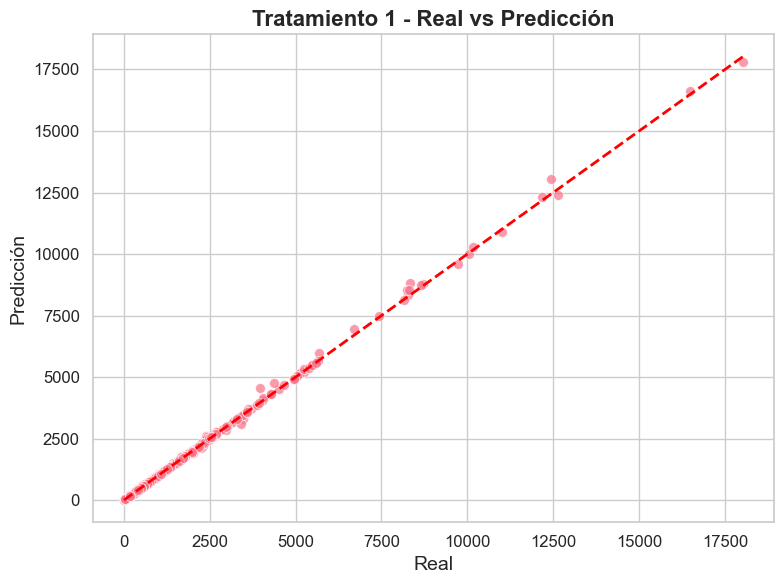

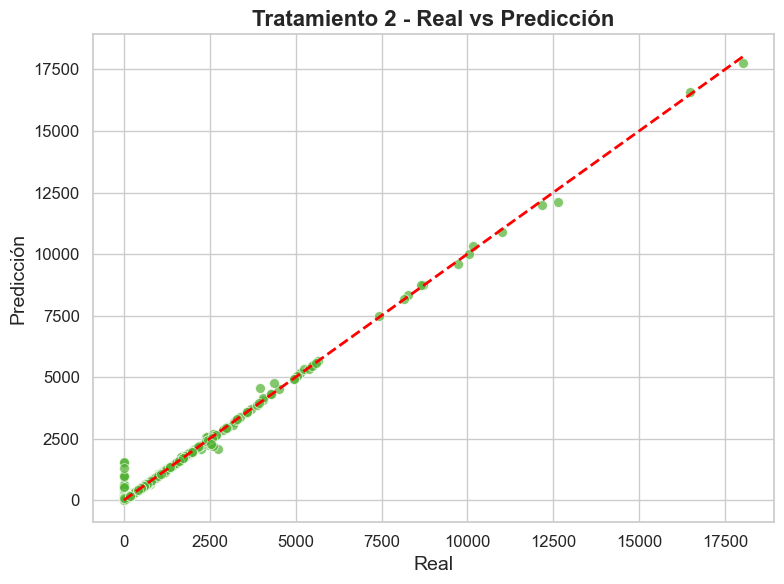

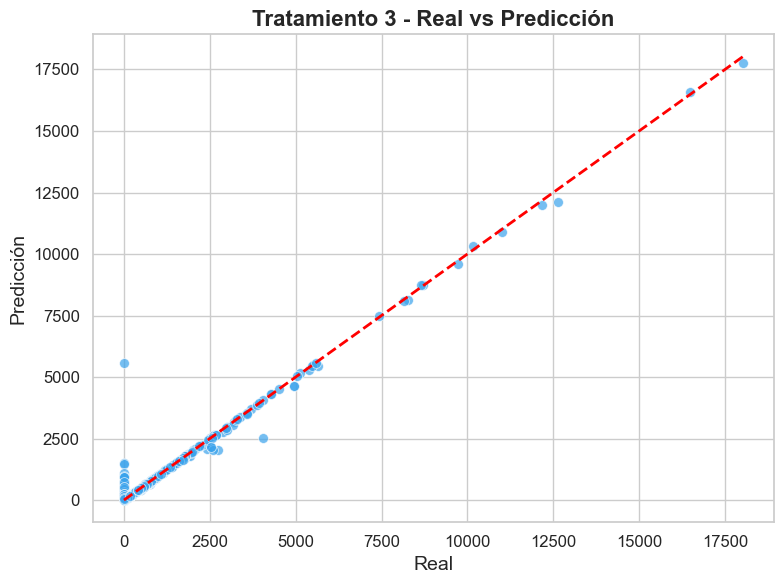

In [4]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# Conexión a la base de datos MySQL
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='tesis123c',
    database='DWH_MEDICINAS_EC'
)

cursor = conn.cursor()

# Consulta SQL optimizada para obtener datos
query = """
SELECT
    COUNT(*) AS total_pacientes,
    ZONA,
    PROVINCIA,
    CONCAT(EXTRACT(YEAR FROM FECHA_ATENCION), 'Q', CEIL(EXTRACT(MONTH FROM FECHA_ATENCION) / 3)) AS trimestre,
    DESCRIPCION_CIE10_1 AS enfermedad,
    COUNT(TRATAMIENTO_1) AS num_tratamientos_1,
    COUNT(TRATAMIENTO_2) AS num_tratamientos_2,
    COUNT(TRATAMIENTO_3) AS num_tratamientos_3
FROM
    consultas_externas
GROUP BY
    ZONA, PROVINCIA, trimestre, DESCRIPCION_CIE10_1
"""

# Cargar los datos en un DataFrame
df = pd.read_sql(query, conn)

# Preprocesamiento: variables categóricas y numéricas
# Convertir variables categóricas con OneHotEncoder
categorical_cols = ['ZONA', 'PROVINCIA', 'enfermedad']  # Aquí incluirías más variables si es necesario

# Escalado de las variables numéricas
numerical_cols = ['total_pacientes']

# Crear transformaciones para cada tipo de columna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

# Entrenamiento: Filtrar los datos de entrada y de salida
X = df[['total_pacientes', 'ZONA', 'PROVINCIA', 'enfermedad']]  # Asegúrate de incluir todas las variables necesarias
y = df[['num_tratamientos_1', 'num_tratamientos_2', 'num_tratamientos_3']]  # Etiquetas de predicción

# Aplicar preprocesamiento
X_processed = preprocessor.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Definir el modelo de regresión
model = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)

# Entrenar el modelo
model.fit(X_train, y_train)

# Predicción en los datos de prueba
predicciones = model.predict(X_test)

# Calcular métricas de validación
mse = mean_squared_error(y_test, predicciones)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predicciones)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R²: {r2}')

# Configuración general para que las gráficas sean más elegantes
sns.set_theme(style="whitegrid", palette="muted")

# Colores para las gráficas
colors = sns.color_palette("husl", 3)

# Crear una gráfica separada para cada tratamiento
for i, (tratamiento, color) in enumerate(zip(['Tratamiento 1', 'Tratamiento 2', 'Tratamiento 3'], colors)):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=y_test.iloc[:, i],
        y=predicciones[:, i],
        color=color,
        alpha=0.7,
        s=50  # Tamaño de los puntos
    )
    plt.plot(
        [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
        [y_test.iloc[:, i].min(), y_test.iloc[:, i].max()],
        color="red",
        linewidth=2,
        linestyle="--"
    )
    plt.title(f'{tratamiento} - Real vs Predicción', fontsize=16, weight="bold")
    plt.xlabel('Real', fontsize=14)
    plt.ylabel('Predicción', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()

# Asignar las predicciones al DataFrame original
df['PREDICCION_DEMANDA_TRATAMIENTO_1'] = model.predict(X_processed)[:, 0]
df['PREDICCION_DEMANDA_TRATAMIENTO_2'] = model.predict(X_processed)[:, 1]
df['PREDICCION_DEMANDA_TRATAMIENTO_3'] = model.predict(X_processed)[:, 2]

# Insertar resultados en la base de datos en lotes de 10,000
batch_size = 10000
data_to_insert = [
    (
        row['enfermedad'], row['trimestre'], row['ZONA'], row['PROVINCIA'], 
        row['PREDICCION_DEMANDA_TRATAMIENTO_1'], row['PREDICCION_DEMANDA_TRATAMIENTO_2'], 
        row['PREDICCION_DEMANDA_TRATAMIENTO_3']
    )
    for _, row in df.iterrows()
]

for i in range(0, len(data_to_insert), batch_size):
    batch = data_to_insert[i:i + batch_size]
    insert_query = """
    INSERT INTO predicciones_demanda (enfermedad, trimestre, zona, provincia, 
                                      prediccion_tratamiento_1, prediccion_tratamiento_2, prediccion_tratamiento_3)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    """
    cursor.executemany(insert_query, batch)
    conn.commit()

# Cerrar la conexión
cursor.close()
conn.close()
